<a href="https://colab.research.google.com/github/dardeshna/frc-stuffs/blob/master/notebooks/optimal_dt_gear_ratio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimal Drivetrain Gear Ratio

This notebook covers formulating drivetrain gear ratio selection as a minimum time optimal control problem. We will explore how to determine the gear ratio that minimizes the travel time over a given distance.

In [ ]:
# setup
import numpy as np
import scipy.integrate
import scipy.optimize
import scipy.interpolate
import cvxpy as cp

import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd, jvp

from jax.config import config
config.update("jax_enable_x64", True)
config.update('jax_platform_name', 'cpu')

from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['svg']
plt.style.use('default')

## DC motor model

Before we set up an optimization problem, we have to define a few system models. We will use the following motor model:

\begin{gather*}
V = I R + k_b w \\
T = k_t I
\end{gather*}

In this model, there are four quantities that vary with time:
* $V$: commanded voltage
* $I$: motor current
* $T$: output torque
* $w$: motor speed

We also have the following parameters:
* $R$: motor resistance
* $k_b$: back-emf constant
* $k_t$: torque constant

We can calculate the parameters from the motor specs as follows:

\begin{gather*}
R = \frac{V_\mathrm{nominal}}{I_\mathrm{stall}} \\
k_b = \frac{V_\mathrm{nominal}}{w_\mathrm{free}} \\
k_t = \frac{T_\mathrm{stall}}{I_\mathrm{stall}}
\end{gather*}

This model encodes the basic behavior of a DC motor. The first equation is a modified version of Ohm's law. It indicates that when a voltage $V$ is first applied, the motor draws current $I$ proportional to the winding resistance $R$. However, as the motor speed $w$ increases, the motor current $I$ decreases. The second equation states that the motor torque $T$ is directly proportional to the motor current $I$. Together, these equations explain why motors produce the maximum torque at stall and no torque at free speed.

Note that this model omits free current which arises due to viscous friction within the motor. The free current of DC motors is typically much smaller than the stall current, so it can be neglected here without introducing significant error.

We will create a Python class that takes in motor specs and calculates the corresponding motor model parameters. We can add an additional parameter `n_motors` which multiplies stall current and stall torque to represent several motors working in parallel.

In [ ]:
class Motor():
    """Motor model

    R = V_n / I_s
    k_b = V_n / w_f
    k_t = T_s / I_s

    R = motor resistance
    k_t = torque constant
    k_b = back-emf constant
    """

    def __init__(self, V_n, w_f, T_s, I_s, n_motors):

        self.V_n = V_n
        self.w_f = w_f
        self.T_s = T_s * n_motors
        self.I_s = I_s * n_motors

        self.R = self.V_n / self.I_s
        self.k_b = self.V_n / self.w_f
        self.k_t = self.T_s / self.I_s

## Drivetrain model

Next, we will define a model of a robot drivetrain. Since we are only interested in straight-line motion of the drivetrain, we only need to define two states: robot position $s$ and velocity $v$. Our input will be the applied motor voltage $V$, and we will consider motor current $I$ as an output of the system so that we can use it later on.

To derive the equations of motion, we start with Newton's second law for the forces acting on the robot, where $m$ and $a$ are the robot mass and acceleration:

\begin{equation*}
\sum F = ma
\end{equation*}

The only force acting on the robot is the force from the drive wheels, which we can rewrite in terms of the motor torque $T$, gear ratio $G$, and wheel radius $r$:

\begin{equation*}
T\frac{G}{r} = ma
\end{equation*}

We can also replace $a$ with $\dot{v}$ since acceleration is the time derivative of velocity:

\begin{equation*}
T\frac{G}{r} = m\dot{v}
\end{equation*}

Now we can substitute in the second equation from our motor model:
\begin{equation*}
k_tI\frac{G}{r} = m\dot{v}
\end{equation*}

Then we can rearrange the first equation from our motor model and substitute it in:
\begin{equation*}
k_t\left(\frac{V - k_b w}{R}\right)\frac{G}{r} = m\dot{v}
\end{equation*}

Next we can rewrite the motor speed $w$ in terms of the robot velocity using the gear ratio $G$ and the wheel radius $r$:
\begin{equation*}
k_t\left(\frac{V - k_b v \frac{G}{r}}{R}\right)\frac{G}{r} = m\dot{v}
\end{equation*}

And finally rearrange:
\begin{equation*}
\dot{v} = - \frac{G^2 k_t k_b }{R m r^2} v + \frac{G k_t}{R m r} V
\end{equation*}

We can also solve for motor current $I$ in terms of voltage and robot velocity:
\begin{equation*}
I = -\frac{G k_b}{Rr} v + \frac{1}{R} V
\end{equation*}

Finally, using the fact that the time derivative of position is velocity, we can write our system model in state space form:

\begin{gather*}
\begin{bmatrix}\dot{s} \\ \dot{v}\end{bmatrix}
=\begin{bmatrix} 0 & 1 \\ 0 & -\frac{G^2 k_t k_b }{R m r^2} \end{bmatrix}
\begin{bmatrix} s \\ v \end{bmatrix}
+ \begin{bmatrix} 0 \\ \frac{G k_t}{R m r} \end{bmatrix} \begin{bmatrix} V \end{bmatrix} \\
\begin{bmatrix}I\end{bmatrix}
= \begin{bmatrix} 0 & -\frac{G k_b}{Rr} \end{bmatrix} \begin{bmatrix} s \\ v \end{bmatrix}
+ \begin{bmatrix}\frac{1}{R}\end{bmatrix} \begin{bmatrix} V \end{bmatrix}
\end{gather*}

Using the typical notation for state-space systems, we have the following:

\begin{gather*}
\dot{\mathbf{x}} = \mathbf{Ax} + \mathbf{Bu} \\
\mathbf{y} = \mathbf{Cx} + \mathbf{Du} \\
\mathbf{x} = \begin{bmatrix} s \\ v \end{bmatrix} \quad \mathbf{u} = \begin{bmatrix} V \end{bmatrix} \quad \mathbf{y} = \begin{bmatrix}I\end{bmatrix} \\
\mathbf{A} = \begin{bmatrix} 0 & 1 \\ 0 & -\frac{G^2 k_t k_b }{R m r^2} \end{bmatrix} \quad \mathbf{B} = \begin{bmatrix} 0 \\ \frac{G k_t}{R m r} \end{bmatrix} \quad \mathbf{C} = \begin{bmatrix} 0 & -\frac{G k_b}{Rr} \end{bmatrix} \quad \mathbf{D} = \begin{bmatrix}\frac{1}{R}\end{bmatrix}
\end{gather*}
We can create another Python class that represents the drivetrain dynamics. We will use lambda functions for the constants so that we can vary $G$ later on.

In [ ]:
class Drivetrain():
    """Drivetrain model

    state: [s, v]
    s = robot position
    v = robot velocity
    
    inputs: [V]
    V = motor voltage

    additional outputs: [I]
    I = motor current

    equations of motion:
    s_dot = v
    v_dot = A_11*v + B*V
    I = C*v + D*V
    
    constants:
    A_11 = -(G^2)*k_t*k_b / (R*m*r^2)
    B = G*k_t / (R*m*r)
    C = -G*k_b / r
    D = 1 / R

    R = motor resistance
    k_t = motor torque constant
    k_b = motor back-emf constant
    G = drivetrain gear ratio
    r = wheel radius
    m = robot mass
    """

    def __init__(self, motor, m, r):
    
        self.A_10 = lambda G : -(G ** 2) * motor.k_t * motor.k_b / (motor.R * m * r ** 2)
        self.B = lambda G : G * motor.k_t / (motor.R * m * r)

        self.C = lambda G : -G * motor.k_b / (motor.R * r)
        self.D = 1 / motor.R

    def f(self, s, v, V, G):

        s_dot = v
        v_dot = self.A_10(G) * v + self.B(G) * V

        return s_dot, v_dot

    def g(self, s, v, V, G):

        I = self.C(G) * v + self.D * V

        return I

## Robot specs

Now that we have a motor and drivetrain model, we need to define our robot specs. We will model a 120lb (55kg) robot with 4 NEO drive motors and 4" wheels. Specs for the NEO and other motors can be found at [motors.vex.com](https://motors.vex.com/).

In [ ]:
# NEO specs
V_nominal = 12 # V
w_free =  5676 * (2 * np.pi / 60) # RPM -> rad/s
T_stall = 2.6 # Nm
I_stall = 105 # A
n_motors = 4

# robot specs
m_robot = 55 # kg
r_wheel = 0.051 # m

# motor and drivetrain models
motor = Motor(V_nominal, w_free, T_stall, I_stall, n_motors)
drivetrain = Drivetrain(motor, m_robot, r_wheel)

## Minimum time problem

With our motor and drivetrain models constructed, we can begin setting up an optimization problem. First, we will consider the case where $G$ is fixed. We are interested in the control signal $\mathbf{u}(t)$, which moves the robot from state $\mathbf{x}_0$ to $\mathbf{x}_f$ in the minimum amount of time $t_f$. For the problem to be well-posed, $\mathbf{u}(t)$ must have upper and lower bounds. Otherwise, we could reach $\mathbf{x}_f$ in an arbitrarily short amount of time with large enough control signals. We can express the minimum time problem most generally as follows:

\begin{align*}
\underset{\mathbf{x}(t), \mathbf{u}(t)}{\text{minimize}} \quad & t_f \\
\text{subject to} \quad & \mathbf{\dot{x}}(t)=\mathbf{Ax}(t)+\mathbf{Bu}(t)\\
  &\mathbf{x}(0) = \mathbf{x}_0 \\
  &\mathbf{x}(t_f) = \mathbf{x}_f \\
  &\mathbf{u}_\mathrm{min} \leq \mathbf{u}(t) \leq \mathbf{u}_\mathrm{max}
\end{align*}

Now we can substitute in our problem's dynamics and boundary conditions:

\begin{align*}
\underset{s(t), v(t), u(t)}{\text{minimize}} \quad & t_f \\
\text{subject to} \quad & \dot{s}(t) = v(t) \\
  & \dot{v}(t) = -\frac{G^2 k_t k_b }{R m r^2}v(t) + \frac{G k_t}{R m r}V(t) \\
  & s(0) = 0 \quad v(0) = 0 \\
  & s(t_f) = s_f \quad v(t_f) = 0 \\
  & -V_\mathrm{max} \leq V(t) \leq V_\mathrm{max} \\
\end{align*}

We will also add constraints on motor current and supply current:

\begin{gather*}
-I_\mathrm{max} \leq I(t) \leq I_\mathrm{max} \\
I(t) V(t) \leq I_\mathrm{batt} V_\mathrm{max} \\
\end{gather*}


Finally, we will add a constraint on voltage ramp rate. This constraint also necessitates boundary conditions at $t=0$ and $t=t_f$ otherwise the change in voltage at the beginning and end of the interval is unbounded.

\begin{gather*}
-\dot{V}_\mathrm{max} \leq \dot{V}(t) \leq \dot{V}_\mathrm{max} \\
V(0) = 0 \quad V(t_f) = 0
\end{gather*}

To solve this optimization problem on a computer, we have to discretize the time interval $[0, t_f]$ into $n$ segments of length $dt$. Note that because $t_f$ is unknown, $dt = \frac{t_f}{n}$ is also unknown.

We can then discretize the differential equations of motion. For simplicity we will choose [forward Euler discretization](https://en.wikipedia.org/wiki/Euler_method) which converts a differential equation $\dot{y} = f(y, t)$ into the recurrence relation $y_{i+1} = y_{i} + f(y_i, t_i) \, dt$. There are also higher order discretization schemes such as the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule_(differential_equations)) which yield better accuracy with fewer points.

Applying forward Euler and substituting, we obtain the final form of our optimization problem:

\begin{align*}
\underset{s_i, v_i, V_i, t_f}{\text{minimize}} \quad & t_f \\
\text{subject to} \quad & s_{i+1} = s_i + v_i \frac{t_f}{n} \\
  & v_{i+1} = v_i + \left(-\frac{G^2 k_t k_b }{R m r^2}v_i + \frac{G k_t}{R m r}V_i \right) \frac{t_f}{n} \\
  & s_0 = 0 \quad v_0 = 0 \quad V_0 = 0 \\
  & s_n = s_f \quad v_n = 0 \quad V_n = 0 \\
  & -V_\mathrm{max} \leq V_i \leq V_\mathrm{max} \\
  & -I_\mathrm{max} \leq -\frac{G k_b}{Rr} v_i + \frac{1}{R} V_i \leq I_\mathrm{max} \\
  & -\frac{G k_b}{Rr} v_i V_i + \frac{1}{R} V_i^2 \leq I_\mathrm{batt} V_\mathrm{max} \\
  & -\dot{V}_\mathrm{max} \leq (V_{i+1}-V_{i})\frac{n}{t_f} \leq \dot{V}_\mathrm{max}
\end{align*}

Before solving the optimization problem we define all remaining constants:

In [ ]:
n = 100 # number of points
G_fixed = 6 # fixed gear ratio

s_0 = 0 # initial position
s_f = 10 # final position
v_0 = 0 # initial velocity
v_f = 0 # final velocity

V_max = 12 # V
I_max = 60 * n_motors # A
I_batt = 200 # A
V_dot_max = V_max/0.1 # V/s

In order to solve this problem, we will use SciPy's `optimize` package. Specifically, we will use [`scipy.optimize.minimize()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) which can solve minimization problems with equality and inequality constraints.

To solve constrained problems, `minimize()` requires the following arguments:
* `fun`: objective function with the signature `f(x) -> y` where `x` is a 1-D array and `y` is a scalar
* `constraints`: dictionary of inequality and equality constraint functions with the signature `c(x) -> y` where `x` is a 1-D array of optimization variables and `y` is a 1-D array of residuals for each constraint
* `x_0`: initial guess for `x`

Since we have split the time interval into $n$ segments, we have $n+1$ points at which $s$, $v$ and $V$ need to be determined. We also need to find $t_f$ which results in a total of $3(n+1)+1$ optimization variables. We will define functions to pack and unpack the vector `x`:


In [ ]:
def unpack(x):

    t_f = x[-1]
    s,v,V = x[:-1].reshape((3, -1))

    return s, v, V, t_f

def pack(s, v, V, t_f):
    
    return np.r_[s, v, V, t_f]

Next we will define a Python function `f(x)` for our optimization objective. Since we are minimizing $t_f$, we just unpack `x` and return `t`. 

We also use the decorator `@jit` which will perform just-in-time compilation using [JAX](https://jax.readthedocs.io/en/latest/index.html). This speeds up solve times since our objective and constraint functions will be called frequently.

In [ ]:
# objective function
@jit
def f(x):
    s, v, V, t_f = unpack(x)
    return t_f

Similarly, we define a function `c_eq(x)` for our equality constrains. This function returns a 1-D array of constraint residuals, and all the residuals should be zero when the equality constraints are satisfied.

Instead of using NumPy which we imported as `np`, we use JAX's NumPy which we have imported as `jnp`. It is designed to be a drop in replacement for NumPy that JAX knows how to compile, and the function signatures are mostly identical to NumPy.

In [ ]:
# equality constraints
@jit
def c_eq(x, G):

    s, v, V, t_f = unpack(x)
    dt = t_f/n

    s_dot, v_dot = drivetrain.f(s, v, V, G) # compute derivatives at each trajectory point

    return jnp.r_[
        s[1:] - (s[:-1] + s_dot[:-1] * dt), # position continuity
        v[1:] - (v[:-1] + v_dot[:-1] * dt), # velocity continuity

        s[0]-s_0, # initial position
        s[-1]-s_f, # final position

        v[0]-v_0, # initial velocity
        v[-1]-v_f, # final velocity
        
        V[0], # initial voltage
        V[-1], # final voltage
    ]

Lastly we define a function `c_ineq(x)` for our inequality constraints. Similar to above, this function returns a 1-D array of constraint residuals. However, these residuals only need to be non-negative for the inequality constraint to be satisfied.

In [ ]:
# inequality constraints (non-negative)
@jit
def c_ineq(x, G):

    s, v, V, t_f = unpack(x)
    dt = t_f/n

    I = drivetrain.g(s, v, V, G) # compute current at each trajectory point
    
    return jnp.r_[
        V_max - jnp.abs(V), # voltage
        I_max - jnp.abs(I), # motor current
        I_batt*V_max - I*V, # supply current
        V_dot_max*dt - jnp.abs(V[1:]-V[:-1]), # ramp rate
    ]

In order to call `minimize()`, we have to provide an initial guess `x_0` for the optimization variables. This initialization does not need to satisfy the constraints but should be roughly what we expect the final solution to look like. For this problem, we will initialize the solver with linear interpolation between $0$ and $s_f$. We will also choose $v = 0$, $V = 0$ and $t_f = 3$.

Note that while `x_0` does not need to satisfy the constraints, the solver can be sensitive to initialization. If the initial guess is too far from the optimal solution, the solver may not converge. Later, we will look at more robust approaches to solve the problem which are not as sensitive to initialization.

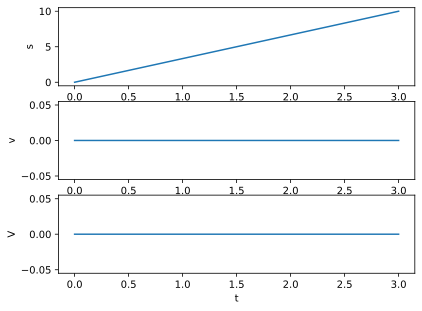

In [ ]:
# linear interpolation initialization
t_f_init = 3
s_init = np.linspace(0, s_f, n+1)
v_init = np.zeros(n+1)
V_init = np.zeros(n+1)

x_0 = pack(
    s = s_init,
    v = v_init,
    V = V_init,
    t_f = t_f_init,
)

# plot initial trajectory
ts = np.linspace(0, t_f_init, n+1)

plt.subplot(3, 1, 1)
plt.plot(ts, s_init)
plt.ylabel('s')

plt.subplot(3, 1, 2)
plt.plot(ts, v_init)
plt.ylabel('v')

plt.subplot(3, 1, 3)
plt.plot(ts, V_init)
plt.ylabel('V')
plt.xlabel('t')

plt.show()

Finally, we define Jacobian functions for the objective and constraints. This step is not neccesary as `minimize()` will default to using finite differences if no Jacobian functions are provided. However, it speeds up solve times and can improve convergence.

In [ ]:
# jacobian of objective function f(s,v,V,t_f)=t_f is zero except for df/dt_f = 1
f_jac = pack(
    s = np.zeros(n+1),
    v = np.zeros(n+1),
    V = np.zeros(n+1),
    t_f = 1,
)

# jacobian function for constraints is generated using JAX
c_eq_jac = jit(jacfwd(c_eq))
c_ineq_jac = jit(jacfwd(c_ineq))

Now we are ready to call `minimize()`:

In [ ]:
# run optimization
res = scipy.optimize.minimize(
    fun = f,
    x0 = x_0,
    jac = lambda x: f_jac,
    constraints = [
        {
            'type': 'eq',
            'fun': c_eq,
            'jac': c_eq_jac,
            'args': (G_fixed,)
        },
        {
            'type': 'ineq',
            'fun': c_ineq,
            'jac': c_ineq_jac,
            'args': (G_fixed,)
        }
    ]
)

# print optimal value
print("t_f: ", res['fun'])

t_f:  2.5021700218044143


Lastly, we can unpack the optimal solution and plot the minimum time trajectory. We will define a function `plot_traj()` so that we can reuse it later on.

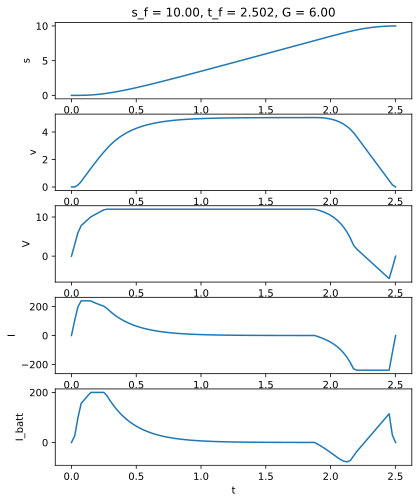

In [ ]:
# unpack optimal point and compute additional quantities of interest
s, v, V, t_f = unpack(res['x'])
_, v_dot = drivetrain.f(s, v, V, G_fixed)
I = drivetrain.g(s, v, V, G_fixed)

# plot optimal trajectory
def plot_traj(n, t_f, s, v, v_dot, V, I, G):

    ts = np.linspace(0,t_f,n+1)

    plt.figure(figsize=(6.4,8))

    plt.subplot(5, 1, 1)
    plt.plot(ts, s)
    plt.ylabel('s')
    plt.title(f's_f = {s[-1]:.2f}, t_f = {ts[-1]:.3f}, G = {G:.2f}')

    plt.subplot(5, 1, 2)
    plt.plot(ts, v)
    plt.ylabel('v')

    plt.subplot(5, 1, 3)
    plt.plot(ts, V)
    plt.ylabel('V')

    plt.subplot(5, 1, 4)
    plt.plot(ts, I)
    plt.ylabel('I')

    plt.subplot(5, 1, 5)
    plt.plot(ts, I*V/V_max)
    plt.ylabel('I_batt')
    plt.xlabel('t')

plot_traj(n, t_f, s, v, v_dot, V, I, G_fixed)
plt.show()

## Optimizing over gear ratios

Now we can consider finding the optimal gear ratio $G^*$. One approach is to convert $G$ from a parameter to another optimization variable in our original minimum time problem. However, because this introduces even more non-convexity into the constraints, it can lead to poor convergence of the solver.

A more robust alternative is to add an outer loop to find $G^*$ by repeatedly solving the original minimum time problem as an inner optimization step. We can do this by defining a function `inner_loop(G)` and calling `scipy.optimize.minimize_scalar()` on this function. We will set `method='bounded'` to use Brent's scalar minimization method, which is a combination of [golden-section search](https://en.wikipedia.org/wiki/Golden-section_search) and [successive parabolic interpolation](https://en.wikipedia.org/wiki/Successive_parabolic_interpolation). We will also assume $G^* \in [3, 8]$.

In [ ]:
# global variables for use across iterations
x = x_0
num_iters = 0

# function for inner optimization loop
def inner_loop(G_iter):

    global x, num_iters

    print(f"---- iteration {num_iters} ----")
    print("G: ", G_iter)

    # solve min time problem with current value of G
    res = scipy.optimize.minimize(
        fun = f,
        x0 = x_0,
        jac = lambda x: f_jac,
        constraints = [
            {
                'type': 'eq',
                'fun': c_eq,
                'jac': c_eq_jac,
                'args': (G_iter,)
            },
            {
                'type': 'ineq',
                'fun': c_ineq,
                'jac': c_ineq_jac,
                'args': (G_iter,)
            }
        ]
    )

    # print optimal value
    print("t_f: ", res['fun'])

    # save optimal point to initialize min time problem in the next iteration
    x = res['x']
    num_iters += 1

    # return final time for use in outer loop
    return res['fun']

# find G_opt that results in minimal time
G_opt = scipy.optimize.minimize_scalar(inner_loop, method='bounded', bounds=(3, 8), options={'xatol':1e-2}).x

---- iteration 0 ----
G:  4.9098300562505255
t_f:  2.386937374076092
---- iteration 1 ----
G:  6.090169943749474
t_f:  2.5173018017551296
---- iteration 2 ----
G:  4.180339887498948
t_f:  2.409074039194193
---- iteration 3 ----
G:  4.750901281609372
t_f:  2.382583591314938
---- iteration 4 ----
G:  4.69501505164819
t_f:  2.3825648781571416
---- iteration 5 ----
G:  4.7216290785686
t_f:  2.382286070510284
---- iteration 6 ----
G:  4.72496248193501
t_f:  2.382269307959653
---- iteration 7 ----
G:  4.737118705952683
t_f:  2.383056628071439
---- iteration 8 ----
G:  4.729605746334903
t_f:  2.3821605378468598
---- iteration 9 ----
G:  4.732939149819626
t_f:  2.3823778761634724


Finally, we can plot the minimum time trajectory for the optimal gear ratio:

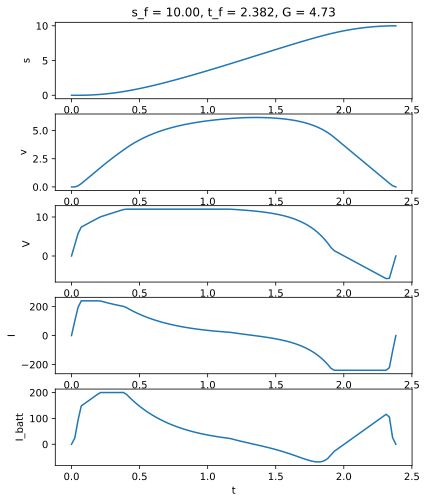

In [ ]:
# unpack optimal point and compute additional quantities of interest
s, v, V, t_f = unpack(x)
_, v_dot = drivetrain.f(s, v, V, G_opt)
I = drivetrain.g(s, v, V, G_opt)

# plot optimal trajectory
plot_traj(n, t_f, s, v, v_dot, V, I, G_opt)
plt.show()

## Bonus: Sequential convex programming (SCP)

As we briefly mentioned earlier, the approach covered in the previous section is not guaranteed to converge to the optimal solution. If the initialization is too far off or the problem is poorly conditioned, then the solver may fail or produce a suboptimal solution.

The underlying issue is that our original optimization problem is minimizing over a set defined by non-convex constraints. This means that the problem may have multiple local minima, which makes it difficult to find the optimal solution. On the other hand, if the problem only had convex constraints, then there would be fast algorithms guaranteed to provide a globally optimal solution.

### Convex optimization

It is worth taking some time to define a convex optimization (convex programming) problem. First, we need to understand convex sets and convex functions. A [convex set](https://en.wikipedia.org/wiki/Convex_set) $C$ is a subset of $\mathbb{R}^n$ (more generally, a Euclidian space) if when given two points $x,y \in C$, the following holds:

\begin{equation*}
(1-t)x+ty \in C \quad \forall t \in [0,1]
\end{equation*}

In other words, you can draw a line segment between two points in a convex set and the line segment remains in the set.

**Convex set:**

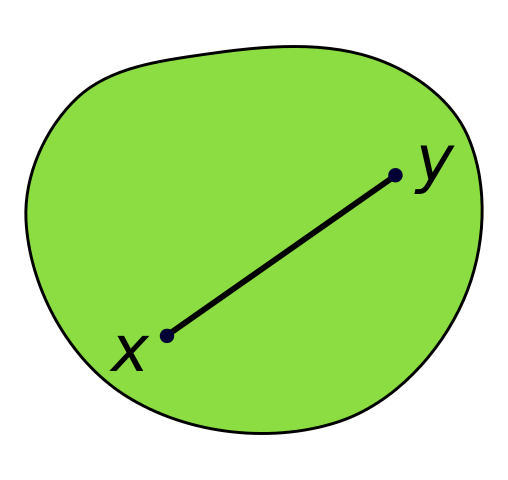

**Non-convex set:**

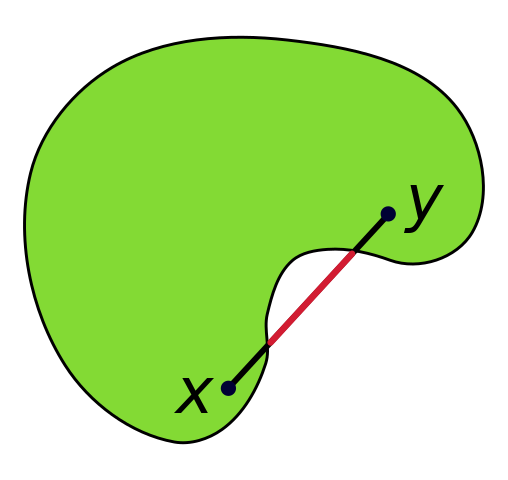

A [convex function](https://en.wikipedia.org/wiki/Convex_function) is one in which the the line segment between any two points on the graph of a function lies above the graph between those two points. More formally, Let $X$ be a convex subset of $\mathbb{R}^n$ and let $f : X \to \mathbb{R}$ be a function. Given any two points $x,y \in X$, then $f$ is convex if the following inequality holds:

\begin{equation*}
f\left(t x + (1-t) y\right) \leq t f\left(x\right) + (1-t) f\left(y\right) \quad \forall t \in [0,1]
\end{equation*}

This is one form of [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality), which holds for all convex functions. It also implies that convex functions have an upwards-facing bowl shape (note that the function need not be differentiable at all points, it can have a sharp corner). In fact, we can describe this fact more precisely by saying that for any convex function, the epigraph (the set defined by all points on or above the function) is a convex set.

Similarly, we can reverse Jensen's inequality to define concave functions. Thus, concave functions look like upside-down bowls and are the negative of convex functions. Note that "concave" and "non-convex" have different meanings—a function that is not convex does not have to be concave.

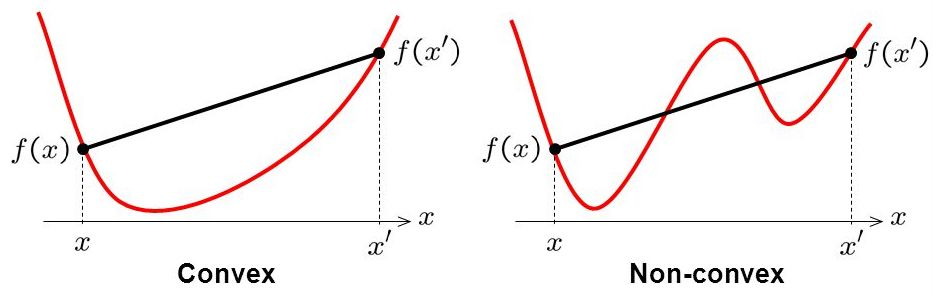

Some examples of convex and concave functions (copied from https://random-walks.org/content/cvx/ch03.html):


**Examples of convex functions in $\mathbb{R}$:**
- affine: $ax + b$, for any $a, b \in \mathbb{R}$
- square: $(ax + b)^2$ for any $a, b \in \mathbb{R}$
- exponential: $e^{\alpha x}$ for any $\alpha \in \mathbb{R}$
- absolute value: $|x|$

**Examples of concave functions in $\mathbb{R}$:**
- affine: $ax + b$, for any $a, b \in \mathbb{R}$.
- logarithm: $\log x$ for $x \in \mathbb{R}_{++}$.

**Examples of convex functions in $\mathbb{R}^n$:**
- affine: $a^\top x + b$, for any $a \in \mathbb{R}^n, b \in \mathbb{R}$.
- norm: $\|x\|_p = \left[ \sum_{i = 1}^n |x_i|^p\right]^{1/p}$ for $p \geq 0$.


With these two definitions, we can define [convex optimization problems](https://en.wikipedia.org/wiki/Convex_optimization) as **minimizing convex functions over convex sets**.

Most general optimization problems can be expressed in standard form where $\mathbf{x} \in \mathbb{R}^n$ is the optimization variable:

\begin{align*}
\underset{\mathbf{x}}{\text{minimize}} \quad & f(\mathbf{x}) \\
\text{subject to} \quad & g_i(\mathbf{x}) \leq 0, \quad i = 1 ,\dotsc, m \\
  & h_i(\mathbf{x}) = 0, \quad i = 1 ,\dotsc, p
\end{align*}

To obtain the standard form for convex optimization problems, we can impose the following restrictions:
* the objective function $f: \mathcal D \subseteq \mathbb{R}^n \to \mathbb{R}$ is a convex function
* the inequality constraint functions $g_i : \mathbb{R}^n \to \mathbb{R}$, $i=1, \ldots, m$, are convex functions
* the equality constraint functions $h_i : \mathbb{R}^n \to \mathbb{R}$, $i=1, \ldots, p$, are affine transformations, that is, of the form: $h_i(\mathbf{x}) = \mathbf{a}_i ^ T \mathbf{x} - b_i$, where $\mathbf{a}_i$ is a vector and $b_i$ is a scalar

This implies the following:
* the feasible set $C$ of the optimization problem consists of all points $\mathbf{x} \in \mathcal{D}$ satisfying the constraints
* $C$ is convex because $\mathcal{D}$ is convex, the sublevel sets of convex functions are convex, affine sets are convex, and the intersection of convex sets is convex.

In summary, the objective function $f$ is defined to be convex and the constraints imply that $C$ is convex, so the problem we just described is a convex optimization problem.

Some useful properties of convex optimization problems that we can exploit are:

* every local minimum is a global minimum
* the optimal set is convex
* if the objective function is strictly convex (replace $\leq$ with $<$ in Jensen's inequality), then the problem has at most one optimal point

In many cases, all three of these hold. Additionally, convex optimization problems can generally be solved with fast, polynomial-time algorithms. Together, these properties make it very desirable to solve convex problems when possible. For more details, see Boyd & Vandenberghe's [Convex Optimization](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf) textbook.

### Minimum time problem as maximum distance problem

Sequential convex programming (SCP) consists of repeatedly solving convex approximations of the original optimization problem. To apply SCP to the minimum time problem, we need two key insights.

The first insight is that we can reformulate the minimum time problem as a maximum distance problem. Intuitively, instead of asking how quickly we can traverse a distance $s_f$, we are asking how far we can go (maximize $s_n$) given $t_f$. We will make this change to the objective and remove the constraint on the final position $s_n$, resulting in the following optimization problem:


\begin{align*}
\underset{s_i, v_i, V_i}{\text{maximize}} \quad & s_n \\
\text{subject to} \quad & s_{i+1} = s_i + v_i \frac{t_f}{n} \\
  & v_{i+1} = v_i + \left(-\frac{G^2 k_t k_b }{R m r^2}v_i + \frac{G k_t}{R m r}V_i \right) \frac{t_f}{n} \\
  & s_0 = 0 \quad v_0 = 0 \quad V_0 = 0 \\
  & v_n = 0 \quad V_n = 0 \\
  & -V_\mathrm{max} \leq V_i \leq V_\mathrm{max} \\
  & -I_\mathrm{max} \leq -\frac{G k_b}{Rr} v_i + \frac{1}{R} V_i \leq I_\mathrm{max} \\
  & -\frac{G k_b}{Rr} v_i V_i + \frac{1}{R} V_i^2 \leq I_\mathrm{batt} V_\mathrm{max} \\
  & -\dot{V}_\mathrm{max} \leq (V_{i+1}-V_{i})\frac{n}{t_f} \leq \dot{V}_\mathrm{max}
\end{align*}

Note that if we know the optimal ${t_f}^*$ from our original minimum time problem, then solving the above problem using ${t_f}^*$ will exactly recover the $s_f$ used in the original problem.

### Convex approximation of the maximum distance problem

The second insight is that the maximum distance problem described above is nearly a convex program since $t_f$ is now a parameter. In fact, all of the inequality constraints except the supply current constraint are affine in the optimization variables, and thus convex.

Let's assume we have an estimate of the velocity $v_i^{(k)}$ and voltage $V_i^{(k)}$ from the latest iteration $k$. Then for the next iteration $k+1$ we can make the supply current constraint convex by linearizing the first term around this estimate. The second term is quadratic so it is already convex.

\begin{gather*}
-\frac{G k_b}{Rr} (-v_i^{(k)} V_i^{(k)} + {v_i} V_i^{(k)} + v_i^{(k)} {V_i}) + \frac{1}{R} V_i^2 \leq I_\mathrm{batt} V_\mathrm{max} \\
\end{gather*}

This results in the following convex optimization problem:

\begin{align*}
\underset{s_i, v_i, V_i}{\text{maximize}} \quad & s_n \\
\text{subject to} \quad & s_{i+1} = s_i + v_i \frac{t_f}{n} \\
  & v_{i+1} = v_i + \left(-\frac{G^2 k_t k_b }{R m r^2}v_i + \frac{G k_t}{R m r}V_i \right) \frac{t_f}{n} \\
  & s_0 = 0 \quad v_0 = 0 \quad V_0 = 0 \\
  & v_n = 0 \quad V_n = 0 \\
  & -V_\mathrm{max} \leq V_i \leq V_\mathrm{max} \\
  & -I_\mathrm{max} \leq -\frac{G k_b}{Rr} v_i + \frac{1}{R} V_i \leq I_\mathrm{max} \\
  & -\frac{G k_b}{Rr} (-v_i^{(k)} V_i^{(k)} + {v_i} V_i^{(k)} + v_i^{(k)} {V_i}) + \frac{1}{R} V_i^2 \leq I_\mathrm{batt} V_\mathrm{max} \\
  & -\dot{V}_\mathrm{max} \leq (V_{i+1}-V_{i})\frac{n}{t_f} \leq \dot{V}_\mathrm{max}
\end{align*}

For $k=0$, we can solve this problem without the supply current constraint. Then we can use $v_i^{(0)}$ and $V_i^{(0)}$ to seed the next iteration $k=1$ with the supply current constraint.

There are many ways to define stopping criteria for SCP. We will look for convergence by checking $\max_i |u_i^{(k+1)} - u_i^{(k)}| < \epsilon $ where $\epsilon$ is a small number such as 1e-6.

Insted of using SciPy's `optimize` package to implement SCP, we will use [CVXPY](https://www.cvxpy.org/) (imported as `cp`) which is purpose-built for solving convex programs. CVXPY implements disciplined convex programming (DCP), where optimization problems are described symbolically and expressions are built from atomic functions with known curvature (convex, concave, or affine). This allows CVXPY to enforce that constructed optimization problems are convex.

First, we have to define symbolic variables and parameters for our problem:

In [ ]:
s = cp.Variable(n+1)
v = cp.Variable(n+1)
V = cp.Variable(n+1)

t_f = cp.Parameter()
v_k = cp.Parameter(n+1)
V_k = cp.Parameter(n+1)
G = cp.Parameter()

# v is a symbolic variable
print("v: ", s)

# t_f is a symbolic parameter
print("t_f: ", t_f)

v:  var1
t_f:  param4


Using these symbolic variables, we can build expressions for intermediate quantities used in the constraints:

In [ ]:
s_dot, v_dot = drivetrain.f(s, v, V, G)
I = drivetrain.g(s, v, V, G)
dt = t_f/n

# v_dot is a symbolic expression
print("v_dot: ", v_dot)

# dt is a symbolic expression
print("dt: ", dt)

v_dot:  Promote(-power(param7, 2.0) @ 0.024761904761904763 @ 0.020188787707217166 / 0.0040872857142857134, (101,)) @ var2 + Promote(param7 @ 0.024761904761904763 / 0.08014285714285714, (101,)) @ var3
dt:  param4 / 100.0


We will define our objective which is to maximize the final position `s[-1]`:

In [ ]:
objective = cp.Maximize(s[-1])

Then we can create lists to store the equality and inequality constraint expressions:

In [ ]:
eq_constraints = [
    s[1:] == (s[:-1] + s_dot[:-1] * dt), # position continuity
    v[1:] == (v[:-1] + v_dot[:-1] * dt), # velocity continuity

    s[0] == s_0, # initial position

    v[0] == v_0, # initial velocity
    v[-1] == v_f, # final velocity

    V[0] == 0, # initial voltage
    V[-1] == 0, # final voltage
]

ineq_constraints = [
    cp.abs(V) <= V_max, # voltage
    cp.abs(I) <= I_max, # motor current
    cp.abs(V[1:]-V[:-1]) <= V_dot_max*dt, # ramp rate
]

linearized_ineq_constraints = [
    drivetrain.C(G) * (-cp.multiply(v_k, V_k) + cp.multiply(v, V_k) + cp.multiply(V, v_k)) + drivetrain.D * V**2 <= I_batt * V_max # supply current
]

Using the objective and constraints, we can form two problems. The first problem, `prob_0` will be used when $k=0$ and will exclude the linearized supply current constraint. The second problem, `prob_1`, will be for $k>0$ and will include the linearized supply current constraint.

In [ ]:
prob_0 = cp.Problem(objective, eq_constraints + ineq_constraints)
prob_1 = cp.Problem(objective, eq_constraints + ineq_constraints + linearized_ineq_constraints)

Finally, we can implement the SCP algorithm by first solving `prob_0`, and then repeatedly solving `prob_1` until convergence:

In [ ]:
max_scp_iters = 20
eps = 1e-6

# function for scp
def scp(verbose=False):

    # solve prob_0 to get v_0 and V_0
    prob_0.solve(ignore_dpp=True)
    scp_iters = 1

    v_k.value = v.value
    V_k.value = V.value

    # repeatedly solve prob_1 with v_k and V_k
    while scp_iters < max_scp_iters:

        prob_1.solve(reltol=1e-5, abstol=1e-5, ignore_dpp=True)
        scp_iters += 1

        # check stopping criteria
        if np.max(np.abs(V.value-V_k.value)) < eps:
            break
        
        v_k.value = v.value
        V_k.value = V.value

    # debug print
    if verbose:
        print("scp_iters: ", scp_iters)
        print("s_f:", prob_1.value)

We will test our SCP algorithm by solving the minimum time problem with fixed gear ratio from earlier. We can use `scipy.optimize.root_scalar()` along with our new `scp()` function to search for a $t_f$ that yields the desired $s_f=10$.

scp_iters:  4
s_f: 2.536838346547798
scp_iters:  3
s_f: 47.80450073938057
scp_iters:  4
s_f: 9.94709371425322
scp_iters:  4
s_f: 10.000095102313736
scp_iters:  4
s_f: 9.999999948868295


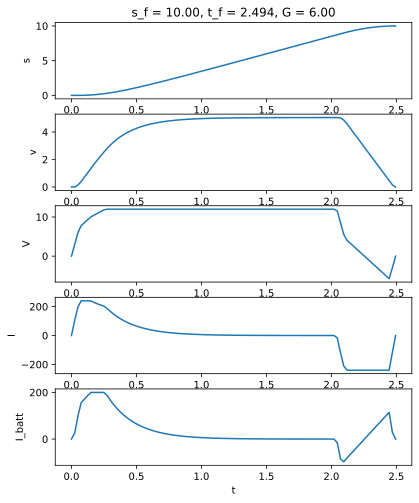

In [ ]:
# set value of G to fixed gear ratio
G.value = G_fixed

# function for inner optimization loop
def inner_loop(t_f_iter):

    # set value of t_f to current iterate
    t_f.value = t_f_iter

    # run scp
    scp(verbose=True)

    # return difference between current and desired final position
    return s.value[-1] - s_f

# find t_f that results in desired s_f
scipy.optimize.root_scalar(inner_loop, x0=1, x1=10)

# plot optimal trajectory
plot_traj(n, t_f.value, s.value, v.value, v_dot.value, V.value, I.value, G_fixed)
plt.show()

Note that SCP is much faster than `scipy.optimize.minimize()` yet the solution is almost idential. In fact, the SCP solution has a slighly lower value for $t_f$ because the SLSQP solver used in `scipy.optimize.minimize()` stops prematurely. In particular, the voltage is held at +12V for longer in the SCP solution before it starts ramping down.

### Optimal gear ratio vs distance

Similar to earlier, we can find the optimal gear ratio $G^*$ by using SCP as an inner loop with `scipy.optimize.minimize_scalar()`. If we sweep over a range of values for $t_f$, we will obtain an optimal gear ratio for each value.

In [ ]:
# global variables for use across iterations
num_iters = 0

# function for inner optimization loop
def inner_loop(G_iter):

    global num_iters

    # set value of G to current iterate
    G.value = G_iter

    # run scp
    scp(verbose=False)
    
    # increment counter
    num_iters += 1

    # return negative of final distance to maximize
    return -s.value[-1]


# range of values for t_f
t_min = 1
t_max = 3
m = 10
ts = np.linspace(t_min, t_max, m)

# initialize arrays for optimal distance and gear ratio
s_f_opt = np.zeros(m)
G_opt = np.zeros(m)

# iterate over values for t_f
for i, t in enumerate(ts):

    print(f"---- t_f = {t} ----")

    # set up variables for current iteration
    t_f.value = t
    num_iters = 0

    # find G_opt that results in maximum distance
    scipy.optimize.minimize_scalar(inner_loop,  method='bounded', bounds=(3,8), options={'xatol':1e-2})

    print("s_f: ", s[-1].value)
    print("G_opt: ", G.value)
    print("num_iters: ", num_iters)

    # save optimal distance and gear ratio to array
    s_f_opt[i] = s[-1].value
    G_opt[i] = G.value

---- t_f = 1.0 ----
s_f:  2.631311487839852
G_opt:  7.159117474002202
num_iters:  11
---- t_f = 1.2222222222222223 ----
s_f:  3.6155592956135116
G_opt:  6.4293610361148925
num_iters:  11
---- t_f = 1.4444444444444444 ----
s_f:  4.694825838399465
G_opt:  5.899561917484547
num_iters:  11
---- t_f = 1.6666666666666665 ----
s_f:  5.869193248794048
G_opt:  5.4665550362593205
num_iters:  15
---- t_f = 1.8888888888888888 ----
s_f:  7.120418592880838
G_opt:  5.1241994845841345
num_iters:  9
---- t_f = 2.111111111111111 ----
s_f:  8.452939634833877
G_opt:  4.860588536666849
num_iters:  12
---- t_f = 2.333333333333333 ----
s_f:  9.858444629509084
G_opt:  4.600085339307093
num_iters:  9
---- t_f = 2.5555555555555554 ----
s_f:  11.340986120167909
G_opt:  4.37810574240702
num_iters:  12
---- t_f = 2.7777777777777777 ----
s_f:  12.885803750279472
G_opt:  4.1844237067594605
num_iters:  11
---- t_f = 3.0 ----
s_f:  14.492735466700092
G_opt:  4.0430487639058414
num_iters:  9


Lastly, we can plot $G$ vs $s_f$ and $t_f$ vs $s_f$:

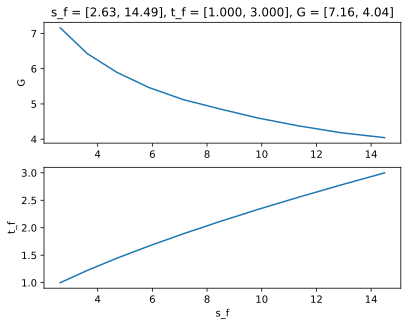

In [ ]:
# plot G vs s_f
plt.subplot(2, 1, 1)
plt.plot(s_f_opt, G_opt)
plt.ylabel('G')
plt.title(f's_f = [{s_f_opt[0]:.2f}, {s_f_opt[-1]:.2f}], t_f = [{ts[0]:.3f}, {ts[-1]:.3f}], G = [{G_opt[0]:.2f}, {G_opt[-1]:.2f}]')

# plot t_f vs s_f
plt.subplot(2, 1, 2)
plt.plot(s_f_opt, ts)
plt.ylabel('t_f')
plt.xlabel('s_f')

plt.show()

This plot illustrates that as distance increases, the optimal gear ratio decreases. In other words, shorter distances benefit from quicker acceleration while longer distances benefit from higher top speed. This relationship can be considered in the context of field layout and cycle paths to find a gear ratio best suited for a particular game and strategy.